In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from pathlib import Path
from typing import Any, Dict, List, Optional

In [2]:
ROOT_DIR = Path("..")
DATA_DIR = ROOT_DIR / "data"
SOURCE_DIR = DATA_DIR / "source"
OUTPUT_DIR = DATA_DIR / "output"
INPUT_PATH = SOURCE_DIR / "OE_Public_Match_Data_cleaned.csv"

In [3]:
df = pd.read_csv(INPUT_PATH)
df.head()

,firsttothreetowers,firstbaron,xpdiffat,firstmidtower,golddiffat,diffkillsat,firstdragon,diffdeathsat,firsttower,firstblood,...,side,diffassistsat,split_Regular,split_Special,playoffs,firstherald,game,patch,minute,result
0,1.0,1.0,-463.0,1.0,-119.0,1.0,0.0,-1.0,1.0,1.0,...,1,3.0,1,0,0,0.0,1.0,3.15,10,1
1,1.0,1.0,63.0,1.0,1272.0,2.0,0.0,-2.0,1.0,1.0,...,1,4.0,1,0,0,0.0,1.0,3.15,15,1
2,1.0,1.0,825.0,1.0,2036.0,2.0,0.0,-2.0,1.0,1.0,...,1,4.0,1,0,0,0.0,1.0,3.15,20,1
3,1.0,1.0,4919.0,1.0,4854.0,6.0,0.0,-6.0,1.0,1.0,...,1,17.0,1,0,0,0.0,1.0,3.15,25,1
4,0.0,0.0,463.0,0.0,119.0,-1.0,1.0,1.0,0.0,0.0,...,0,-3.0,1,0,0,0.0,1.0,3.15,10,0


In [4]:
feature_columns = [col for col in df.columns if col != 'result']
X = df[feature_columns].values
y = df['result'].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution: {np.bincount(y)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train_scaled.shape}, {y_train.shape}")
print(f"Validation set: {X_val_scaled.shape}, {y_val.shape}")
print(f"Test set: {X_test_scaled.shape}, {y_test.shape}")

Features shape: (731240, 20)
Target shape: (731240,)
Target distribution: [365792 365448]
Train set: (438744, 20), (438744,)
Validation set: (146248, 20), (146248,)
Test set: (146248, 20), (146248,)


In [5]:
class LogisticRegression:
    def __init__(self):
        self.weights = None
        self.bias = None

    def _sigmoid(self, z):
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def _compute_loss(self, X, y):
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        predictions = np.clip(predictions, 1e-15, 1 - 1e-15)
        loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
        return loss

    def _compute_gradient(self, X, y):
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        dw = (1 / len(y)) * X.T @ (predictions - y)
        db = (1 / len(y)) * np.sum(predictions - y)
        return dw, db

    def predict_proba(self, X):
        z = X @ self.weights + self.bias
        return self._sigmoid(z)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

In [6]:
class SGDOptimizer:
    """
    Stochastic Gradient Descent optimizer with early stopping and logging capabilities.
    
    Features:
    - Fixed learning rate
    - Early stopping based on loss improvement threshold
    - Configurable logging intervals
    - Loss history tracking
    """
    
    def __init__(self, learning_rate=0.01, max_epochs=1000, early_stop_patience=50, 
                 early_stop_threshold=1e-6, log_interval=10, verbose=True):
        """
        Initialize SGD optimizer.
        
        Args:
            learning_rate (float): Fixed learning rate for gradient descent
            max_epochs (int): Maximum number of training epochs
            early_stop_patience (int): Number of epochs to wait for improvement before stopping
            early_stop_threshold (float): Minimum improvement threshold for early stopping
            log_interval (int): Log metrics every n epochs
            verbose (bool): Whether to print training progress
        """
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.log_interval = log_interval
        self.verbose = verbose
        
        # Training history
        self.loss_history = []
        self.epoch_history = []
        self.stopped_early = False
        self.final_epoch = 0
        
    def optimize(self, model, X_train, y_train, X_val=None, y_val=None):
        """
        Optimize model parameters using SGD with early stopping.
        
        Args:
            model: Model object with _compute_loss and _compute_gradient methods
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)
            
        Returns:
            dict: Training history and statistics
        """
        # Initialize weights if not already done
        if model.weights is None:
            model.weights = np.random.normal(0, 0.01, X_train.shape[1])
            model.bias = 0.0
            
        # Track best loss for early stopping
        best_loss = float('inf')
        patience_counter = 0
        
        if self.verbose:
            print(f"Starting SGD training with learning rate: {self.learning_rate}")
            print(f"Early stopping: patience={self.early_stop_patience}, threshold={self.early_stop_threshold}")
            print("-" * 60)
            
        start_time = time.time()
        
        for epoch in range(self.max_epochs):
            # Compute loss and gradients
            train_loss = model._compute_loss(X_train, y_train)
            dw, db = model._compute_gradient(X_train, y_train)
            
            # Update parameters
            model.weights -= self.learning_rate * dw
            model.bias -= self.learning_rate * db
            
            # Store history
            self.loss_history.append(train_loss)
            self.epoch_history.append(epoch)
            
            # Check for early stopping
            if train_loss < best_loss - self.early_stop_threshold:
                best_loss = train_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            # Log progress
            if (epoch + 1) % self.log_interval == 0 and self.verbose:
                val_loss_str = ""
                if X_val is not None and y_val is not None:
                    val_loss = model._compute_loss(X_val, y_val)
                    val_loss_str = f", Val Loss: {val_loss:.6f}"
                    
                elapsed_time = time.time() - start_time
                print(f"Epoch {epoch+1:4d} | Train Loss: {train_loss:.6f}{val_loss_str} | "
                      f"LR: {self.learning_rate:.4f} | Patience: {patience_counter:2d}/{self.early_stop_patience} | "
                      f"Time: {elapsed_time:.2f}s")
                
            # Early stopping check
            if patience_counter >= self.early_stop_patience:
                self.stopped_early = True
                self.final_epoch = epoch + 1
                if self.verbose:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    print(f"No improvement in loss for {self.early_stop_patience} epochs "
                          f"(threshold: {self.early_stop_threshold})")
                break
                
        if not self.stopped_early:
            self.final_epoch = self.max_epochs
            if self.verbose:
                print(f"\nTraining completed after {self.max_epochs} epochs")
                
        training_time = time.time() - start_time
        final_loss = self.loss_history[-1]
        
        if self.verbose:
            print(f"Final loss: {final_loss:.6f}")
            print(f"Total training time: {training_time:.2f}s")
            print(f"Average time per epoch: {training_time/self.final_epoch:.4f}s")
            
        return {
            'loss_history': self.loss_history.copy(),
            'epoch_history': self.epoch_history.copy(),
            'final_loss': final_loss,
            'final_epoch': self.final_epoch,
            'stopped_early': self.stopped_early,
            'training_time': training_time,
            'learning_rate': self.learning_rate
        }
    
    def plot_loss_curve(self, title="SGD Loss Curve"):
        """Plot the loss curve from training history."""
        if not self.loss_history:
            print("No training history available. Run optimize() first.")
            return
            
        plt.figure(figsize=(10, 6))
        plt.plot(self.epoch_history, self.loss_history, 'b-', linewidth=2, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{title} (LR: {self.learning_rate})')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        if self.stopped_early:
            plt.axvline(x=self.final_epoch-1, color='r', linestyle='--', alpha=0.7, 
                       label=f'Early Stop (Epoch {self.final_epoch})')
            plt.legend()
            
        plt.tight_layout()
        plt.show()

In [7]:
class SGDBacktrackingOptimizer:
    """
    Stochastic Gradient Descent with Backtracking Line Search.
    
    Features:
    - Adaptive step size using Armijo line search condition
    - Backtracking algorithm with configurable parameters
    - Early stopping based on loss improvement threshold
    - Configurable logging intervals
    - Step size history tracking
    """
    
    def __init__(self, initial_learning_rate=1.0, c1=1e-4, rho=0.5, max_epochs=1000, 
                 early_stop_patience=50, early_stop_threshold=1e-6, log_interval=10, 
                 max_backtrack_iter=20, verbose=True):
        """
        Initialize SGD Backtracking optimizer.
        
        Args:
            initial_learning_rate (float): Initial step size for backtracking
            c1 (float): Armijo condition parameter (0 < c1 < 1)
            rho (float): Step size reduction factor (0 < rho < 1)
            max_epochs (int): Maximum number of training epochs
            early_stop_patience (int): Number of epochs to wait for improvement before stopping
            early_stop_threshold (float): Minimum improvement threshold for early stopping
            log_interval (int): Log metrics every n epochs
            max_backtrack_iter (int): Maximum backtracking iterations per epoch
            verbose (bool): Whether to print training progress
        """
        self.initial_learning_rate = initial_learning_rate
        self.c1 = c1  # Armijo parameter
        self.rho = rho  # Step reduction factor
        self.max_epochs = max_epochs
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.log_interval = log_interval
        self.max_backtrack_iter = max_backtrack_iter
        self.verbose = verbose
        
        # Training history
        self.loss_history = []
        self.epoch_history = []
        self.step_size_history = []
        self.backtrack_iterations_history = []
        self.stopped_early = False
        self.final_epoch = 0
        
    def _armijo_condition(self, f_current, f_new, grad_dot_direction, step_size):
        """
        Check Armijo sufficient decrease condition.
        
        Args:
            f_current: Current function value
            f_new: New function value after step
            grad_dot_direction: Gradient dot product with search direction
            step_size: Current step size
            
        Returns:
            bool: True if Armijo condition is satisfied
        """
        return f_new <= f_current + self.c1 * step_size * grad_dot_direction
    
    def _backtracking_line_search(self, model, X, y, current_weights, current_bias, 
                                  dw, db, current_loss):
        """
        Perform backtracking line search to find suitable step size.
        
        Args:
            model: Model object
            X: Input features
            y: Target values
            current_weights: Current weight parameters
            current_bias: Current bias parameter
            dw: Weight gradients
            db: Bias gradient
            current_loss: Current loss value
            
        Returns:
            tuple: (step_size, backtrack_iterations)
        """
        step_size = self.initial_learning_rate
        
        # Compute gradient norm squared (for descent direction)
        grad_norm_sq = np.sum(dw**2) + db**2
        
        # Search direction is negative gradient
        direction_dot_grad = -grad_norm_sq
        
        backtrack_iter = 0
        
        for i in range(self.max_backtrack_iter):
            # Try step with current step size
            new_weights = current_weights - step_size * dw
            new_bias = current_bias - step_size * db
            
            # Temporarily update model parameters to compute new loss
            old_weights = model.weights.copy()
            old_bias = model.bias
            
            model.weights = new_weights
            model.bias = new_bias
            
            new_loss = model._compute_loss(X, y)
            
            # Restore original parameters
            model.weights = old_weights
            model.bias = old_bias
            
            # Check Armijo condition
            if self._armijo_condition(current_loss, new_loss, direction_dot_grad, step_size):
                break
                
            # Reduce step size
            step_size *= self.rho
            backtrack_iter += 1
            
        return step_size, backtrack_iter
        
    def optimize(self, model, X_train, y_train, X_val=None, y_val=None):
        """
        Optimize model parameters using SGD with backtracking line search.
        
        Args:
            model: Model object with _compute_loss and _compute_gradient methods
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)
            
        Returns:
            dict: Training history and statistics
        """
        # Initialize weights if not already done
        if model.weights is None:
            model.weights = np.random.normal(0, 0.01, X_train.shape[1])
            model.bias = 0.0
            
        # Track best loss for early stopping
        best_loss = float('inf')
        patience_counter = 0
        
        if self.verbose:
            print(f"Starting SGD with Backtracking Line Search")
            print(f"Initial step size: {self.initial_learning_rate}, c1: {self.c1}, rho: {self.rho}")
            print(f"Early stopping: patience={self.early_stop_patience}, threshold={self.early_stop_threshold}")
            print("-" * 80)
            
        start_time = time.time()
        
        for epoch in range(self.max_epochs):
            # Compute loss and gradients
            train_loss = model._compute_loss(X_train, y_train)
            dw, db = model._compute_gradient(X_train, y_train)
            
            # Perform backtracking line search
            step_size, backtrack_iter = self._backtracking_line_search(
                model, X_train, y_train, model.weights, model.bias, dw, db, train_loss
            )
            
            # Update parameters with found step size
            model.weights -= step_size * dw
            model.bias -= step_size * db
            
            # Store history
            self.loss_history.append(train_loss)
            self.epoch_history.append(epoch)
            self.step_size_history.append(step_size)
            self.backtrack_iterations_history.append(backtrack_iter)
            
            # Check for early stopping
            if train_loss < best_loss - self.early_stop_threshold:
                best_loss = train_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            # Log progress
            if (epoch + 1) % self.log_interval == 0 and self.verbose:
                val_loss_str = ""
                if X_val is not None and y_val is not None:
                    val_loss = model._compute_loss(X_val, y_val)
                    val_loss_str = f", Val Loss: {val_loss:.6f}"
                    
                elapsed_time = time.time() - start_time
                avg_step_size = np.mean(self.step_size_history[-self.log_interval:])
                avg_backtrack = np.mean(self.backtrack_iterations_history[-self.log_interval:])
                
                print(f"Epoch {epoch+1:4d} | Train Loss: {train_loss:.6f}{val_loss_str} | "
                      f"Step Size: {step_size:.6f} | Avg Step: {avg_step_size:.6f} | "
                      f"Backtrack: {backtrack_iter:2d} | Avg BT: {avg_backtrack:.1f} | "
                      f"Patience: {patience_counter:2d}/{self.early_stop_patience} | Time: {elapsed_time:.2f}s")
                
            # Early stopping check
            if patience_counter >= self.early_stop_patience:
                self.stopped_early = True
                self.final_epoch = epoch + 1
                if self.verbose:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    print(f"No improvement in loss for {self.early_stop_patience} epochs "
                          f"(threshold: {self.early_stop_threshold})")
                break
                
        if not self.stopped_early:
            self.final_epoch = self.max_epochs
            if self.verbose:
                print(f"\nTraining completed after {self.max_epochs} epochs")
                
        training_time = time.time() - start_time
        final_loss = self.loss_history[-1]
        
        if self.verbose:
            print(f"Final loss: {final_loss:.6f}")
            print(f"Total training time: {training_time:.2f}s")
            print(f"Average time per epoch: {training_time/self.final_epoch:.4f}s")
            print(f"Average step size: {np.mean(self.step_size_history):.6f}")
            print(f"Final step size: {self.step_size_history[-1]:.6f}")
            print(f"Average backtrack iterations: {np.mean(self.backtrack_iterations_history):.2f}")
            
        return {
            'loss_history': self.loss_history.copy(),
            'epoch_history': self.epoch_history.copy(),
            'step_size_history': self.step_size_history.copy(),
            'backtrack_iterations_history': self.backtrack_iterations_history.copy(),
            'final_loss': final_loss,
            'final_epoch': self.final_epoch,
            'stopped_early': self.stopped_early,
            'training_time': training_time,
            'initial_learning_rate': self.initial_learning_rate,
            'avg_step_size': np.mean(self.step_size_history),
            'final_step_size': self.step_size_history[-1],
            'avg_backtrack_iterations': np.mean(self.backtrack_iterations_history)
        }
    
    def plot_training_curves(self, title="SGD Backtracking Training Curves"):
        """Plot loss curve and step size evolution."""
        if not self.loss_history:
            print("No training history available. Run optimize() first.")
            return
            
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
        
        # Plot 1: Loss curve
        ax1.plot(self.epoch_history, self.loss_history, 'b-', linewidth=2, label='Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'{title} - Loss Evolution')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        if self.stopped_early:
            ax1.axvline(x=self.final_epoch-1, color='r', linestyle='--', alpha=0.7, 
                       label=f'Early Stop (Epoch {self.final_epoch})')
            ax1.legend()
        
        # Plot 2: Step size evolution
        ax2.plot(self.epoch_history, self.step_size_history, 'g-', linewidth=2, label='Step Size')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Step Size')
        ax2.set_title('Step Size Evolution')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.set_yscale('log')  # Log scale for better visualization
        
        # Plot 3: Backtrack iterations
        ax3.plot(self.epoch_history, self.backtrack_iterations_history, 'r-', linewidth=2, 
                label='Backtrack Iterations')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Backtrack Iterations')
        ax3.set_title('Backtracking Iterations per Epoch')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
            
        plt.tight_layout()
        plt.show()

In [8]:
class LogisticRegressionSGDBacktrack:
    """
    Logistic Regression with SGD Backtracking Line Search optimization.
    """
    
    def __init__(self, optimizer=None):
        """
        Initialize logistic regression model with backtracking optimizer.
        
        Args:
            optimizer: SGDBacktrackingOptimizer instance. If None, uses default settings.
        """
        self.weights = None
        self.bias = None
        self.optimizer = optimizer or SGDBacktrackingOptimizer()
        self.training_history: Optional[Dict[str, Any]] = None
        
    def _sigmoid(self, z):
        """Sigmoid activation function with clipping for numerical stability."""
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def _compute_loss(self, X, y):
        """Compute logistic loss (cross-entropy)."""
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        predictions = np.clip(predictions, 1e-15, 1 - 1e-15)
        loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
        return loss

    def _compute_gradient(self, X, y):
        """Compute gradients for weights and bias."""
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        dw = (1 / len(y)) * X.T @ (predictions - y)
        db = (1 / len(y)) * np.sum(predictions - y)
        return dw, db
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        Train the model using SGD with backtracking line search.
        
        Args:
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)
            
        Returns:
            self: Returns the fitted model
        """
        self.training_history = self.optimizer.optimize(
            self, X_train, y_train, X_val, y_val
        )
        return self

    def predict_proba(self, X):
        """Predict class probabilities."""
        if self.weights is None:
            raise ValueError("Model must be fitted before making predictions")
        z = X @ self.weights + self.bias
        return self._sigmoid(z)

    def predict(self, X):
        """Predict class labels."""
        return (self.predict_proba(X) >= 0.5).astype(int)
    
    def evaluate(self, X, y):
        """
        Evaluate model performance.
        
        Returns:
            dict: Dictionary containing loss and accuracy
        """
        if self.weights is None:
            raise ValueError("Model must be fitted before evaluation")
            
        loss = self._compute_loss(X, y)
        predictions = self.predict(X)
        accuracy = accuracy_score(y, predictions)
        
        return {
            'loss': loss,
            'accuracy': accuracy
        }
    
    def get_training_summary(self):
        """Get a summary of the training process."""
        if self.training_history is None:
            return "Model has not been trained yet."
            
        summary = f"""
Training Summary (SGD Backtracking):
===================================
Initial Step Size: {self.training_history['initial_learning_rate']:.6f}
Final Epoch: {self.training_history['final_epoch']}
Final Loss: {self.training_history['final_loss']:.6f}
Training Time: {self.training_history['training_time']:.2f}s
Early Stopping: {'Yes' if self.training_history['stopped_early'] else 'No'}
Average Time/Epoch: {self.training_history['training_time']/self.training_history['final_epoch']:.4f}s
Average Step Size: {self.training_history['avg_step_size']:.6f}
Final Step Size: {self.training_history['final_step_size']:.6f}
Average Backtrack Iterations: {self.training_history['avg_backtrack_iterations']:.2f}
"""
        return summary

In [9]:
class LogisticRegressionSGD:
    """
    Logistic Regression with SGD optimization and early stopping.
    """

    def __init__(self, optimizer=None):
        """
        Initialize logistic regression model.

        Args:
            optimizer: SGDOptimizer instance. If None, uses default SGD settings.
        """
        self.weights = None
        self.bias = None
        self.optimizer = optimizer or SGDOptimizer()
        self.training_history: Optional[Dict[str, Any]] = None

    def _sigmoid(self, z):
        """Sigmoid activation function with clipping for numerical stability."""
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def _compute_loss(self, X, y):
        """Compute logistic loss (cross-entropy)."""
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        predictions = np.clip(predictions, 1e-15, 1 - 1e-15)
        loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
        return loss

    def _compute_gradient(self, X, y):
        """Compute gradients for weights and bias."""
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        dw = (1 / len(y)) * X.T @ (predictions - y)
        db = (1 / len(y)) * np.sum(predictions - y)
        return dw, db

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        Train the model using SGD optimization.

        Args:
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)

        Returns:
            self: Returns the fitted model
        """
        self.training_history = self.optimizer.optimize(
            self, X_train, y_train, X_val, y_val
        )
        return self

    def predict_proba(self, X):
        """Predict class probabilities."""
        if self.weights is None:
            raise ValueError("Model must be fitted before making predictions")
        z = X @ self.weights + self.bias
        return self._sigmoid(z)

    def predict(self, X):
        """Predict class labels."""
        return (self.predict_proba(X) >= 0.5).astype(int)

    def evaluate(self, X, y):
        """
        Evaluate model performance.

        Returns:
            dict: Dictionary containing loss and accuracy
        """
        if self.weights is None:
            raise ValueError("Model must be fitted before evaluation")

        loss = self._compute_loss(X, y)
        predictions = self.predict(X)
        accuracy = accuracy_score(y, predictions)

        return {"loss": loss, "accuracy": accuracy}

    def get_training_summary(self):
        """Get a summary of the training process."""
        if self.training_history is None:
            return "Model has not been trained yet."

        summary = f"""
Training Summary:
================
Learning Rate: {self.training_history['learning_rate']:.6f}
Final Epoch: {self.training_history['final_epoch']}
Final Loss: {self.training_history['final_loss']:.6f}
Training Time: {self.training_history['training_time']:.2f}s
Early Stopping: {'Yes' if self.training_history['stopped_early'] else 'No'}
Average Time/Epoch: {self.training_history['training_time']/self.training_history['final_epoch']:.4f}s
"""
        return summary

In [ ]:
# Test and compare SGD Fixed vs SGD Backtracking
def compare_sgd_methods():
    """
    Compare SGD with fixed learning rates vs SGD with backtracking line search.
    """
    print("Comparing SGD Methods: Fixed Learning Rate vs Backtracking")
    print("=" * 70)
    print()
    MAX_EPOCHS = 5000
    EARLY_STOP_THRESHOLD = 1e-4
    
    results = {}
    
    # Test 1: SGD with Fixed Learning Rates
    print("1. Testing SGD with Fixed Learning Rates")
    print("-" * 45)
    
    fixed_learning_rates = [0.01, 0.1, 0.5]
    
    for lr in fixed_learning_rates:
        print(f"\nTesting Fixed LR = {lr}")
        
        optimizer = SGDOptimizer(
            learning_rate=lr,
            max_epochs=MAX_EPOCHS,
            early_stop_patience=50,
            early_stop_threshold=EARLY_STOP_THRESHOLD,
            log_interval=50,
            verbose=True
        )
        
        model = LogisticRegressionSGD(optimizer=optimizer)
        
        start_time = time.time()
        model.fit(X_train_scaled, y_train, X_val_scaled, y_val)
        total_time = time.time() - start_time
        
        # Evaluate performance
        train_metrics = model.evaluate(X_train_scaled, y_train)
        val_metrics = model.evaluate(X_val_scaled, y_val)
        test_metrics = model.evaluate(X_test_scaled, y_test)
        
        results[f'fixed_{lr}'] = {
            'method': f'Fixed LR {lr}',
            'model': model,
            'training_history': model.training_history,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics,
            'test_metrics': test_metrics,
            'total_time': total_time,
            'optimizer_type': 'fixed'
        }
        
        print(f"Results: Epochs={model.training_history['final_epoch']}, "
              f"Final Loss={train_metrics['loss']:.6f}, "
              f"Test Acc={test_metrics['accuracy']:.4f}, "
              f"Time={total_time:.2f}s")
    
    print("\n" + "="*70)
    print("2. Testing SGD with Backtracking Line Search")
    print("-" * 45)
    
    # Test 2: SGD with Backtracking (different initial step sizes)
    initial_step_sizes = [0.1, 1.0, 5.0]
    
    for initial_step in initial_step_sizes:
        print(f"\nTesting Backtracking with Initial Step = {initial_step}")
        
        optimizer = SGDBacktrackingOptimizer(
            initial_learning_rate=initial_step,
            c1=1e-4,
            rho=0.5,
            max_epochs=MAX_EPOCHS,
            early_stop_patience=50,
            early_stop_threshold=EARLY_STOP_THRESHOLD,
            log_interval=50,
            max_backtrack_iter=20,
            verbose=True
        )
        
        model = LogisticRegressionSGDBacktrack(optimizer=optimizer)
        
        start_time = time.time()
        model.fit(X_train_scaled, y_train, X_val_scaled, y_val)
        total_time = time.time() - start_time
        
        # Evaluate performance
        train_metrics = model.evaluate(X_train_scaled, y_train)
        val_metrics = model.evaluate(X_val_scaled, y_val)
        test_metrics = model.evaluate(X_test_scaled, y_test)
        
        results[f'backtrack_{initial_step}'] = {
            'method': f'Backtrack Init {initial_step}',
            'model': model,
            'training_history': model.training_history,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics,
            'test_metrics': test_metrics,
            'total_time': total_time,
            'optimizer_type': 'backtrack'
        }
        
        print(f"Results: Epochs={model.training_history['final_epoch']}, "
              f"Final Loss={train_metrics['loss']:.6f}, "
              f"Test Acc={test_metrics['accuracy']:.4f}, "
              f"Time={total_time:.2f}s, "
              f"Avg Step={model.training_history['avg_step_size']:.6f}")
    
    return results

# Run the comparison
sgd_comparison_results = compare_sgd_methods()

Comparing SGD Methods: Fixed Learning Rate vs Backtracking

1. Testing SGD with Fixed Learning Rates
---------------------------------------------

Testing Fixed LR = 0.01
Starting SGD training with learning rate: 0.01
Early stopping: patience=50, threshold=0.0001
------------------------------------------------------------
Epoch   50 | Train Loss: 0.541306, Val Loss: 0.539594 | LR: 0.0100 | Patience:  0/50 | Time: 1.81s
Epoch  100 | Train Loss: 0.489021, Val Loss: 0.488131 | LR: 0.0100 | Patience:  0/50 | Time: 3.57s
Epoch  150 | Train Loss: 0.464613, Val Loss: 0.463983 | LR: 0.0100 | Patience:  0/50 | Time: 5.40s
Epoch  200 | Train Loss: 0.450699, Val Loss: 0.450184 | LR: 0.0100 | Patience:  0/50 | Time: 7.15s
Epoch  250 | Train Loss: 0.441692, Val Loss: 0.441245 | LR: 0.0100 | Patience:  0/50 | Time: 8.98s
Epoch  300 | Train Loss: 0.435328, Val Loss: 0.434927 | LR: 0.0100 | Patience:  0/50 | Time: 10.72s
Epoch  350 | Train Loss: 0.430538, Val Loss: 0.430174 | LR: 0.0100 | Patience: 

In [23]:
def plot_loss_convergence_separate(results):
    fixed_results = {k: v for k, v in results.items() if v["optimizer_type"] == "fixed"}
    backtrack_results = {
        k: v for k, v in results.items() if v["optimizer_type"] == "backtrack"
    }

    # Fixed learning rate
    plt.figure(figsize=(8, 6))
    for key, result in fixed_results.items():
        history = result["training_history"]
        plt.plot(
            history["epoch_history"],
            history["loss_history"],
            label=result["method"],
            linewidth=2,
        )
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Loss Convergence (Fixed Learning Rate)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "sgd" / "loss_fixed.png")
    plt.close()

    # Backtracking
    plt.figure(figsize=(8, 6))
    for key, result in backtrack_results.items():
        history = result["training_history"]
        plt.plot(
            history["epoch_history"],
            history["loss_history"],
            label=result["method"],
            linewidth=2,
        )
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Loss Convergence (Backtracking)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "sgd" / "loss_backtrack.png")
    plt.close()


plot_loss_convergence_separate(sgd_comparison_results)

In [10]:
class AGDOptimizer:
    """
    Accelerated Gradient Descent (Nesterov's method) optimizer with early stopping and logging capabilities.
    
    Features:
    - Fixed learning rate with momentum acceleration
    - Nesterov momentum for improved convergence
    - Early stopping based on loss improvement threshold
    - Configurable logging intervals
    - Loss and momentum history tracking
    """
    
    def __init__(self, learning_rate=0.01, momentum=0.9, max_epochs=1000, early_stop_patience=50, 
                 early_stop_threshold=1e-6, log_interval=10, verbose=True):
        """
        Initialize AGD optimizer.
        
        Args:
            learning_rate (float): Fixed learning rate for gradient descent
            momentum (float): Momentum coefficient (0 <= momentum < 1)
            max_epochs (int): Maximum number of training epochs
            early_stop_patience (int): Number of epochs to wait for improvement before stopping
            early_stop_threshold (float): Minimum improvement threshold for early stopping
            log_interval (int): Log metrics every n epochs
            verbose (bool): Whether to print training progress
        """
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_epochs = max_epochs
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.log_interval = log_interval
        self.verbose = verbose
        
        # Training history
        self.loss_history = []
        self.epoch_history = []
        self.stopped_early = False
        self.final_epoch = 0
        
        # Momentum variables
        self.velocity_w = None
        self.velocity_b = None
        
    def optimize(self, model, X_train, y_train, X_val=None, y_val=None):
        """
        Optimize model parameters using AGD with Nesterov momentum.
        
        Args:
            model: Model object with _compute_loss and _compute_gradient methods
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)
            
        Returns:
            dict: Training history and statistics
        """
        # Initialize weights if not already done
        if model.weights is None:
            model.weights = np.random.normal(0, 0.01, X_train.shape[1])
            model.bias = 0.0
            
        # Initialize momentum variables
        self.velocity_w = np.zeros_like(model.weights)
        self.velocity_b = 0.0
            
        # Track best loss for early stopping
        best_loss = float('inf')
        patience_counter = 0
        
        if self.verbose:
            print(f"Starting AGD training with learning rate: {self.learning_rate}, momentum: {self.momentum}")
            print(f"Early stopping: patience={self.early_stop_patience}, threshold={self.early_stop_threshold}")
            print("-" * 60)
            
        start_time = time.time()
        
        for epoch in range(self.max_epochs):
            # Nesterov momentum: compute gradients at the lookahead position
            # Store current parameters
            current_weights = model.weights.copy()
            current_bias = model.bias
            
            # Move to lookahead position
            model.weights = current_weights + self.momentum * self.velocity_w
            model.bias = current_bias + self.momentum * self.velocity_b
            
            # Compute loss at current position (before update) for monitoring
            model.weights = current_weights
            model.bias = current_bias
            train_loss = model._compute_loss(X_train, y_train)
            
            # Compute gradients at lookahead position
            model.weights = current_weights + self.momentum * self.velocity_w
            model.bias = current_bias + self.momentum * self.velocity_b
            dw, db = model._compute_gradient(X_train, y_train)
            
            # Update velocity
            self.velocity_w = self.momentum * self.velocity_w - self.learning_rate * dw
            self.velocity_b = self.momentum * self.velocity_b - self.learning_rate * db
            
            # Update parameters
            model.weights = current_weights + self.velocity_w
            model.bias = current_bias + self.velocity_b
            
            # Store history
            self.loss_history.append(train_loss)
            self.epoch_history.append(epoch)
            
            # Check for early stopping
            if train_loss < best_loss - self.early_stop_threshold:
                best_loss = train_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            # Log progress
            if (epoch + 1) % self.log_interval == 0 and self.verbose:
                val_loss_str = ""
                if X_val is not None and y_val is not None:
                    val_loss = model._compute_loss(X_val, y_val)
                    val_loss_str = f", Val Loss: {val_loss:.6f}"
                    
                elapsed_time = time.time() - start_time
                print(f"Epoch {epoch+1:4d} | Train Loss: {train_loss:.6f}{val_loss_str} | "
                      f"LR: {self.learning_rate:.4f} | Momentum: {self.momentum:.3f} | "
                      f"Patience: {patience_counter:2d}/{self.early_stop_patience} | "
                      f"Time: {elapsed_time:.2f}s")
                
            # Early stopping check
            if patience_counter >= self.early_stop_patience:
                self.stopped_early = True
                self.final_epoch = epoch + 1
                if self.verbose:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    print(f"No improvement in loss for {self.early_stop_patience} epochs "
                          f"(threshold: {self.early_stop_threshold})")
                break
                
        if not self.stopped_early:
            self.final_epoch = self.max_epochs
            if self.verbose:
                print(f"\nTraining completed after {self.max_epochs} epochs")
                
        training_time = time.time() - start_time
        final_loss = self.loss_history[-1]
        
        if self.verbose:
            print(f"Final loss: {final_loss:.6f}")
            print(f"Total training time: {training_time:.2f}s")
            print(f"Average time per epoch: {training_time/self.final_epoch:.4f}s")
            
        return {
            'loss_history': self.loss_history.copy(),
            'epoch_history': self.epoch_history.copy(),
            'final_loss': final_loss,
            'final_epoch': self.final_epoch,
            'stopped_early': self.stopped_early,
            'training_time': training_time,
            'learning_rate': self.learning_rate,
            'momentum': self.momentum
        }
    
    def plot_loss_curve(self, title="AGD Loss Curve"):
        """Plot the loss curve from training history."""
        if not self.loss_history:
            print("No training history available. Run optimize() first.")
            return
            
        plt.figure(figsize=(10, 6))
        plt.plot(self.epoch_history, self.loss_history, 'b-', linewidth=2, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{title} (LR: {self.learning_rate}, Momentum: {self.momentum})')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        if self.stopped_early:
            plt.axvline(x=self.final_epoch-1, color='r', linestyle='--', alpha=0.7, 
                       label=f'Early Stop (Epoch {self.final_epoch})')
            plt.legend()
            
        plt.tight_layout()
        plt.show()

In [11]:
class AGDBacktrackingOptimizer:
    """
    Accelerated Gradient Descent with Backtracking Line Search.
    
    Features:
    - Nesterov momentum acceleration
    - Adaptive step size using Armijo line search condition
    - Backtracking algorithm with configurable parameters
    - Early stopping based on loss improvement threshold
    - Configurable logging intervals
    - Step size and momentum history tracking
    """
    
    def __init__(self, initial_learning_rate=1.0, momentum=0.9, c1=1e-4, rho=0.5, 
                 max_epochs=1000, early_stop_patience=50, early_stop_threshold=1e-6, 
                 log_interval=10, max_backtrack_iter=20, verbose=True):
        """
        Initialize AGD Backtracking optimizer.
        
        Args:
            initial_learning_rate (float): Initial step size for backtracking
            momentum (float): Momentum coefficient (0 <= momentum < 1)
            c1 (float): Armijo condition parameter (0 < c1 < 1)
            rho (float): Step size reduction factor (0 < rho < 1)
            max_epochs (int): Maximum number of training epochs
            early_stop_patience (int): Number of epochs to wait for improvement before stopping
            early_stop_threshold (float): Minimum improvement threshold for early stopping
            log_interval (int): Log metrics every n epochs
            max_backtrack_iter (int): Maximum backtracking iterations per epoch
            verbose (bool): Whether to print training progress
        """
        self.initial_learning_rate = initial_learning_rate
        self.momentum = momentum
        self.c1 = c1  # Armijo parameter
        self.rho = rho  # Step reduction factor
        self.max_epochs = max_epochs
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.log_interval = log_interval
        self.max_backtrack_iter = max_backtrack_iter
        self.verbose = verbose
        
        # Training history
        self.loss_history = []
        self.epoch_history = []
        self.step_size_history = []
        self.backtrack_iterations_history = []
        self.stopped_early = False
        self.final_epoch = 0
        
        # Momentum variables
        self.velocity_w = None
        self.velocity_b = None
        
    def _armijo_condition(self, f_current, f_new, grad_dot_direction, step_size):
        """
        Check Armijo sufficient decrease condition.
        
        Args:
            f_current: Current function value
            f_new: New function value after step
            grad_dot_direction: Gradient dot product with search direction
            step_size: Current step size
            
        Returns:
            bool: True if Armijo condition is satisfied
        """
        return f_new <= f_current + self.c1 * step_size * grad_dot_direction
    
    def _backtracking_line_search_agd(self, model, X, y, current_weights, current_bias,
                                      velocity_w, velocity_b, dw, db, current_loss):
        """
        Perform backtracking line search for AGD to find suitable step size.
        
        Args:
            model: Model object
            X: Input features
            y: Target values
            current_weights: Current weight parameters
            current_bias: Current bias parameter
            velocity_w: Current weight velocity
            velocity_b: Current bias velocity
            dw: Weight gradients
            db: Bias gradient
            current_loss: Current loss value
            
        Returns:
            tuple: (step_size, backtrack_iterations)
        """
        step_size = self.initial_learning_rate
        
        # Compute gradient norm squared (for descent direction)
        grad_norm_sq = np.sum(dw**2) + db**2
        
        # Search direction is negative gradient (velocity update direction)
        direction_dot_grad = -grad_norm_sq
        
        backtrack_iter = 0
        
        for i in range(self.max_backtrack_iter):
            # Try step with current step size
            # Update velocity
            new_velocity_w = self.momentum * velocity_w - step_size * dw
            new_velocity_b = self.momentum * velocity_b - step_size * db
            
            # Update parameters
            new_weights = current_weights + new_velocity_w
            new_bias = current_bias + new_velocity_b
            
            # Temporarily update model parameters to compute new loss
            old_weights = model.weights.copy()
            old_bias = model.bias
            
            model.weights = new_weights
            model.bias = new_bias
            
            new_loss = model._compute_loss(X, y)
            
            # Restore original parameters
            model.weights = old_weights
            model.bias = old_bias
            
            # Check Armijo condition
            if self._armijo_condition(current_loss, new_loss, direction_dot_grad, step_size):
                break
                
            # Reduce step size
            step_size *= self.rho
            backtrack_iter += 1
            
        return step_size, backtrack_iter
        
    def optimize(self, model, X_train, y_train, X_val=None, y_val=None):
        """
        Optimize model parameters using AGD with backtracking line search.
        
        Args:
            model: Model object with _compute_loss and _compute_gradient methods
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)
            
        Returns:
            dict: Training history and statistics
        """
        # Initialize weights if not already done
        if model.weights is None:
            model.weights = np.random.normal(0, 0.01, X_train.shape[1])
            model.bias = 0.0
            
        # Initialize momentum variables
        self.velocity_w = np.zeros_like(model.weights)
        self.velocity_b = 0.0
            
        # Track best loss for early stopping
        best_loss = float('inf')
        patience_counter = 0
        
        if self.verbose:
            print(f"Starting AGD with Backtracking Line Search")
            print(f"Initial step size: {self.initial_learning_rate}, momentum: {self.momentum}")
            print(f"c1: {self.c1}, rho: {self.rho}")
            print(f"Early stopping: patience={self.early_stop_patience}, threshold={self.early_stop_threshold}")
            print("-" * 80)
            
        start_time = time.time()
        
        for epoch in range(self.max_epochs):
            # Nesterov momentum: compute gradients at the lookahead position
            # Store current parameters
            current_weights = model.weights.copy()
            current_bias = model.bias
            
            # Move to lookahead position for gradient computation
            lookahead_weights = current_weights + self.momentum * self.velocity_w
            lookahead_bias = current_bias + self.momentum * self.velocity_b
            
            # Compute loss at current position (before update) for monitoring
            train_loss = model._compute_loss(X_train, y_train)
            
            # Compute gradients at lookahead position
            model.weights = lookahead_weights
            model.bias = lookahead_bias
            dw, db = model._compute_gradient(X_train, y_train)
            
            # Restore current position
            model.weights = current_weights
            model.bias = current_bias
            
            # Perform backtracking line search
            step_size, backtrack_iter = self._backtracking_line_search_agd(
                model, X_train, y_train, current_weights, current_bias,
                self.velocity_w, self.velocity_b, dw, db, train_loss
            )
            
            # Update velocity with found step size
            self.velocity_w = self.momentum * self.velocity_w - step_size * dw
            self.velocity_b = self.momentum * self.velocity_b - step_size * db
            
            # Update parameters
            model.weights = current_weights + self.velocity_w
            model.bias = current_bias + self.velocity_b
            
            # Store history
            self.loss_history.append(train_loss)
            self.epoch_history.append(epoch)
            self.step_size_history.append(step_size)
            self.backtrack_iterations_history.append(backtrack_iter)
            
            # Check for early stopping
            if train_loss < best_loss - self.early_stop_threshold:
                best_loss = train_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            # Log progress
            if (epoch + 1) % self.log_interval == 0 and self.verbose:
                val_loss_str = ""
                if X_val is not None and y_val is not None:
                    val_loss = model._compute_loss(X_val, y_val)
                    val_loss_str = f", Val Loss: {val_loss:.6f}"
                    
                elapsed_time = time.time() - start_time
                avg_step_size = np.mean(self.step_size_history[-self.log_interval:])
                avg_backtrack = np.mean(self.backtrack_iterations_history[-self.log_interval:])
                
                print(f"Epoch {epoch+1:4d} | Train Loss: {train_loss:.6f}{val_loss_str} | "
                      f"Step Size: {step_size:.6f} | Avg Step: {avg_step_size:.6f} | "
                      f"Momentum: {self.momentum:.3f} | Backtrack: {backtrack_iter:2d} | "
                      f"Avg BT: {avg_backtrack:.1f} | Patience: {patience_counter:2d}/{self.early_stop_patience} | "
                      f"Time: {elapsed_time:.2f}s")
                
            # Early stopping check
            if patience_counter >= self.early_stop_patience:
                self.stopped_early = True
                self.final_epoch = epoch + 1
                if self.verbose:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    print(f"No improvement in loss for {self.early_stop_patience} epochs "
                          f"(threshold: {self.early_stop_threshold})")
                break
                
        if not self.stopped_early:
            self.final_epoch = self.max_epochs
            if self.verbose:
                print(f"\nTraining completed after {self.max_epochs} epochs")
                
        training_time = time.time() - start_time
        final_loss = self.loss_history[-1]
        
        if self.verbose:
            print(f"Final loss: {final_loss:.6f}")
            print(f"Total training time: {training_time:.2f}s")
            print(f"Average time per epoch: {training_time/self.final_epoch:.4f}s")
            print(f"Average step size: {np.mean(self.step_size_history):.6f}")
            print(f"Final step size: {self.step_size_history[-1]:.6f}")
            print(f"Average backtrack iterations: {np.mean(self.backtrack_iterations_history):.2f}")
            
        return {
            'loss_history': self.loss_history.copy(),
            'epoch_history': self.epoch_history.copy(),
            'step_size_history': self.step_size_history.copy(),
            'backtrack_iterations_history': self.backtrack_iterations_history.copy(),
            'final_loss': final_loss,
            'final_epoch': self.final_epoch,
            'stopped_early': self.stopped_early,
            'training_time': training_time,
            'initial_learning_rate': self.initial_learning_rate,
            'momentum': self.momentum,
            'avg_step_size': np.mean(self.step_size_history),
            'final_step_size': self.step_size_history[-1],
            'avg_backtrack_iterations': np.mean(self.backtrack_iterations_history)
        }
    
    def plot_training_curves(self, title="AGD Backtracking Training Curves"):
        """Plot loss curve and step size evolution."""
        if not self.loss_history:
            print("No training history available. Run optimize() first.")
            return
            
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
        
        # Plot 1: Loss curve
        ax1.plot(self.epoch_history, self.loss_history, 'b-', linewidth=2, label='Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'{title} - Loss Evolution (Momentum: {self.momentum})')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        if self.stopped_early:
            ax1.axvline(x=self.final_epoch-1, color='r', linestyle='--', alpha=0.7, 
                       label=f'Early Stop (Epoch {self.final_epoch})')
            ax1.legend()
        
        # Plot 2: Step size evolution
        ax2.plot(self.epoch_history, self.step_size_history, 'g-', linewidth=2, label='Step Size')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Step Size')
        ax2.set_title('Step Size Evolution')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.set_yscale('log')  # Log scale for better visualization
        
        # Plot 3: Backtrack iterations
        ax3.plot(self.epoch_history, self.backtrack_iterations_history, 'r-', linewidth=2, 
                label='Backtrack Iterations')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Backtrack Iterations')
        ax3.set_title('Backtracking Iterations per Epoch')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
            
        plt.tight_layout()
        plt.show()

In [12]:
class LogisticRegressionAGD:
    """
    Logistic Regression with AGD (Accelerated Gradient Descent) optimization and early stopping.
    """

    def __init__(self, optimizer=None):
        """
        Initialize logistic regression model with AGD optimizer.

        Args:
            optimizer: AGDOptimizer instance. If None, uses default AGD settings.
        """
        self.weights = None
        self.bias = None
        self.optimizer = optimizer or AGDOptimizer()
        self.training_history: Optional[Dict[str, Any]] = None

    def _sigmoid(self, z):
        """Sigmoid activation function with clipping for numerical stability."""
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def _compute_loss(self, X, y):
        """Compute logistic loss (cross-entropy)."""
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        predictions = np.clip(predictions, 1e-15, 1 - 1e-15)
        loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
        return loss

    def _compute_gradient(self, X, y):
        """Compute gradients for weights and bias."""
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        dw = (1 / len(y)) * X.T @ (predictions - y)
        db = (1 / len(y)) * np.sum(predictions - y)
        return dw, db

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        Train the model using AGD optimization.

        Args:
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)

        Returns:
            self: Returns the fitted model
        """
        self.training_history = self.optimizer.optimize(
            self, X_train, y_train, X_val, y_val
        )
        return self

    def predict_proba(self, X):
        """Predict class probabilities."""
        if self.weights is None:
            raise ValueError("Model must be fitted before making predictions")
        z = X @ self.weights + self.bias
        return self._sigmoid(z)

    def predict(self, X):
        """Predict class labels."""
        return (self.predict_proba(X) >= 0.5).astype(int)

    def evaluate(self, X, y):
        """
        Evaluate model performance.

        Returns:
            dict: Dictionary containing loss and accuracy
        """
        if self.weights is None:
            raise ValueError("Model must be fitted before evaluation")

        loss = self._compute_loss(X, y)
        predictions = self.predict(X)
        accuracy = accuracy_score(y, predictions)

        return {"loss": loss, "accuracy": accuracy}

    def get_training_summary(self):
        """Get a summary of the training process."""
        if self.training_history is None:
            return "Model has not been trained yet."

        summary = f"""
Training Summary (AGD):
======================
Learning Rate: {self.training_history['learning_rate']:.6f}
Momentum: {self.training_history['momentum']:.3f}
Final Epoch: {self.training_history['final_epoch']}
Final Loss: {self.training_history['final_loss']:.6f}
Training Time: {self.training_history['training_time']:.2f}s
Early Stopping: {'Yes' if self.training_history['stopped_early'] else 'No'}
Average Time/Epoch: {self.training_history['training_time']/self.training_history['final_epoch']:.4f}s
"""
        return summary

In [13]:
class LogisticRegressionAGDBacktrack:
    """
    Logistic Regression with AGD Backtracking Line Search optimization.
    """
    
    def __init__(self, optimizer=None):
        """
        Initialize logistic regression model with AGD backtracking optimizer.
        
        Args:
            optimizer: AGDBacktrackingOptimizer instance. If None, uses default settings.
        """
        self.weights = None
        self.bias = None
        self.optimizer = optimizer or AGDBacktrackingOptimizer()
        self.training_history: Optional[Dict[str, Any]] = None
        
    def _sigmoid(self, z):
        """Sigmoid activation function with clipping for numerical stability."""
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def _compute_loss(self, X, y):
        """Compute logistic loss (cross-entropy)."""
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        predictions = np.clip(predictions, 1e-15, 1 - 1e-15)
        loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
        return loss

    def _compute_gradient(self, X, y):
        """Compute gradients for weights and bias."""
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        dw = (1 / len(y)) * X.T @ (predictions - y)
        db = (1 / len(y)) * np.sum(predictions - y)
        return dw, db
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        Train the model using AGD with backtracking line search.
        
        Args:
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)
            
        Returns:
            self: Returns the fitted model
        """
        self.training_history = self.optimizer.optimize(
            self, X_train, y_train, X_val, y_val
        )
        return self

    def predict_proba(self, X):
        """Predict class probabilities."""
        if self.weights is None:
            raise ValueError("Model must be fitted before making predictions")
        z = X @ self.weights + self.bias
        return self._sigmoid(z)

    def predict(self, X):
        """Predict class labels."""
        return (self.predict_proba(X) >= 0.5).astype(int)
    
    def evaluate(self, X, y):
        """
        Evaluate model performance.
        
        Returns:
            dict: Dictionary containing loss and accuracy
        """
        if self.weights is None:
            raise ValueError("Model must be fitted before evaluation")
            
        loss = self._compute_loss(X, y)
        predictions = self.predict(X)
        accuracy = accuracy_score(y, predictions)
        
        return {
            'loss': loss,
            'accuracy': accuracy
        }
    
    def get_training_summary(self):
        """Get a summary of the training process."""
        if self.training_history is None:
            return "Model has not been trained yet."
            
        summary = f"""
Training Summary (AGD Backtracking):
===================================
Initial Step Size: {self.training_history['initial_learning_rate']:.6f}
Momentum: {self.training_history['momentum']:.3f}
Final Epoch: {self.training_history['final_epoch']}
Final Loss: {self.training_history['final_loss']:.6f}
Training Time: {self.training_history['training_time']:.2f}s
Early Stopping: {'Yes' if self.training_history['stopped_early'] else 'No'}
Average Time/Epoch: {self.training_history['training_time']/self.training_history['final_epoch']:.4f}s
Average Step Size: {self.training_history['avg_step_size']:.6f}
Final Step Size: {self.training_history['final_step_size']:.6f}
Average Backtrack Iterations: {self.training_history['avg_backtrack_iterations']:.2f}
"""
        return summary

In [22]:
# Test and compare AGD methods: Fixed learning rates vs Backtracking
def compare_agd_methods():
    """
    Compare AGD with fixed learning rates vs AGD with backtracking line search.
    Tests different learning rates and momentum values.
    """
    print("Comparing AGD Methods: Fixed Learning Rate vs Backtracking")
    print("=" * 70)
    print()
    MAX_EPOCHS = 20000
    EARLY_STOP_THRESHOLD = 1e-6
    
    results = {}
    
    # Test 1: AGD with Fixed Learning Rates
    print("1. Testing AGD with Fixed Learning Rates")
    print("-" * 45)
    
    # Test different combinations of learning rates and momentum
    fixed_configs = [
        (0.01, 0.9),   # Standard setting
        (0.1, 0.9),    # Higher LR
        (0.01, 0.95),  # Higher momentum
        (0.1, 0.95)    # Both higher
    ]
    
    for lr, momentum in fixed_configs:
        print(f"\nTesting Fixed LR = {lr}, Momentum = {momentum}")
        
        optimizer = AGDOptimizer(
            learning_rate=lr,
            momentum=momentum,
            max_epochs=MAX_EPOCHS,
            early_stop_patience=50,
            early_stop_threshold=EARLY_STOP_THRESHOLD,
            log_interval=50,
            verbose=True
        )
        
        model = LogisticRegressionAGD(optimizer=optimizer)
        
        start_time = time.time()
        model.fit(X_train_scaled, y_train, X_val_scaled, y_val)
        total_time = time.time() - start_time
        
        # Evaluate performance
        train_metrics = model.evaluate(X_train_scaled, y_train)
        val_metrics = model.evaluate(X_val_scaled, y_val)
        test_metrics = model.evaluate(X_test_scaled, y_test)
        
        config_key = f'agd_fixed_{lr}_{momentum}'
        results[config_key] = {
            'method': f'AGD Fixed LR {lr}, Mom {momentum}',
            'model': model,
            'training_history': model.training_history,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics,
            'test_metrics': test_metrics,
            'total_time': total_time,
            'optimizer_type': 'agd_fixed',
            'lr': lr,
            'momentum': momentum
        }
        
        print(f"Results: Epochs={model.training_history['final_epoch']}, "
              f"Final Loss={train_metrics['loss']:.6f}, "
              f"Test Acc={test_metrics['accuracy']:.4f}, "
              f"Time={total_time:.2f}s")
    
    print("\n" + "="*70)
    print("2. Testing AGD with Backtracking Line Search")
    print("-" * 45)
    
    # Test 2: AGD with Backtracking (different initial step sizes and momentum)
    backtrack_configs = [
        (1.0, 0.9),    # Standard setting
        (5.0, 0.9),    # Higher initial step
        (1.0, 0.95),   # Higher momentum
        (10.0, 0.9)    # Very high initial step
    ]
    
    for initial_step, momentum in backtrack_configs:
        print(f"\nTesting Backtracking with Initial Step = {initial_step}, Momentum = {momentum}")
        
        optimizer = AGDBacktrackingOptimizer(
            initial_learning_rate=initial_step,
            momentum=momentum,
            c1=1e-4,
            rho=0.5,
            max_epochs=MAX_EPOCHS,
            early_stop_patience=50,
            early_stop_threshold=EARLY_STOP_THRESHOLD,
            log_interval=50,
            max_backtrack_iter=20,
            verbose=True
        )
        
        model = LogisticRegressionAGDBacktrack(optimizer=optimizer)
        
        start_time = time.time()
        model.fit(X_train_scaled, y_train, X_val_scaled, y_val)
        total_time = time.time() - start_time
        
        # Evaluate performance
        train_metrics = model.evaluate(X_train_scaled, y_train)
        val_metrics = model.evaluate(X_val_scaled, y_val)
        test_metrics = model.evaluate(X_test_scaled, y_test)
        
        config_key = f'agd_backtrack_{initial_step}_{momentum}'
        results[config_key] = {
            'method': f'AGD Backtrack Init {initial_step}, Mom {momentum}',
            'model': model,
            'training_history': model.training_history,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics,
            'test_metrics': test_metrics,
            'total_time': total_time,
            'optimizer_type': 'agd_backtrack',
            'initial_step': initial_step,
            'momentum': momentum
        }
        
        print(f"Results: Epochs={model.training_history['final_epoch']}, "
              f"Final Loss={train_metrics['loss']:.6f}, "
              f"Test Acc={test_metrics['accuracy']:.4f}, "
              f"Time={total_time:.2f}s, "
              f"Avg Step={model.training_history['avg_step_size']:.6f}")
    
    return results

In [8]:
def plot_agd_convergence_comparison(results):
    """
    Plot convergence comparison for AGD methods.
    """
    # Separate fixed and backtracking results
    fixed_results = {k: v for k, v in results.items() if v["optimizer_type"] == "agd_fixed"}
    backtrack_results = {k: v for k, v in results.items() if v["optimizer_type"] == "agd_backtrack"}

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: AGD Fixed - Loss convergence
    for key, result in fixed_results.items():
        history = result["training_history"]
        ax1.plot(
            history["epoch_history"],
            history["loss_history"],
            label=f'LR {result["lr"]}, Mom {result["momentum"]}',
            linewidth=2,
        )
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Training Loss")
    ax1.set_title("AGD Fixed Learning Rate - Loss Convergence")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: AGD Backtracking - Loss convergence
    for key, result in backtrack_results.items():
        history = result["training_history"]
        ax2.plot(
            history["epoch_history"],
            history["loss_history"],
            label=f'Init {result["initial_step"]}, Mom {result["momentum"]}',
            linewidth=2,
        )
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Training Loss")
    ax2.set_title("AGD Backtracking - Loss Convergence")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Step size evolution for backtracking methods
    for key, result in backtrack_results.items():
        history = result["training_history"]
        ax3.plot(
            history["epoch_history"],
            history["step_size_history"],
            label=f'Init {result["initial_step"]}, Mom {result["momentum"]}',
            linewidth=2,
        )
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Step Size")
    ax3.set_title("AGD Backtracking - Step Size Evolution")
    ax3.set_yscale("log")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Performance comparison bar chart
    methods = []
    test_accuracies = []
    final_losses = []
    epochs = []
    
    for key, result in results.items():
        methods.append(result["method"][:20])  # Truncate for display
        test_accuracies.append(result["test_metrics"]["accuracy"])
        final_losses.append(result["train_metrics"]["loss"])
        epochs.append(result["training_history"]["final_epoch"])

    x_pos = np.arange(len(methods))
    ax4.bar(x_pos, test_accuracies, alpha=0.7, color='skyblue')
    ax4.set_xlabel("Method")
    ax4.set_ylabel("Test Accuracy")
    ax4.set_title("AGD Methods - Test Accuracy Comparison")
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(methods, rotation=45, ha='right')
    ax4.grid(True, alpha=0.3)

    # Add accuracy values on bars
    for i, acc in enumerate(test_accuracies):
        ax4.text(i, acc + 0.001, f'{acc:.3f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

def print_agd_summary_table(results):
    """
    Print a comprehensive summary table of AGD results.
    """
    print("\n" + "="*100)
    print("AGD METHODS COMPARISON SUMMARY")
    print("="*100)
    print(f"{'Method':<25} {'Epochs':<8} {'Final Loss':<12} {'Test Acc':<10} {'Time (s)':<10} {'Avg Step':<12}")
    print("-"*100)
    
    for key, result in results.items():
        method = result["method"]
        epochs = result["training_history"]["final_epoch"]
        final_loss = result["train_metrics"]["loss"]
        test_acc = result["test_metrics"]["accuracy"]
        time_taken = result["total_time"]
        
        if "avg_step_size" in result["training_history"]:
            avg_step = result["training_history"]["avg_step_size"]
            step_str = f"{avg_step:.6f}"
        else:
            step_str = f"{result['lr']:.6f}" if 'lr' in result else "N/A"
        
        print(f"{method:<25} {epochs:<8} {final_loss:<12.6f} {test_acc:<10.4f} "
              f"{time_taken:<10.2f} {step_str:<12}")
    
    print("-"*100)

In [23]:
# Run the AGD comparison
print("Starting AGD Methods Comparison...")
agd_comparison_results = compare_agd_methods()

Starting AGD Methods Comparison...
Comparing AGD Methods: Fixed Learning Rate vs Backtracking

1. Testing AGD with Fixed Learning Rates
---------------------------------------------

Testing Fixed LR = 0.01, Momentum = 0.9
Starting AGD training with learning rate: 0.01, momentum: 0.9
Early stopping: patience=50, threshold=1e-06
------------------------------------------------------------
Epoch   50 | Train Loss: 0.422632, Val Loss: 0.421760 | LR: 0.0100 | Momentum: 0.900 | Patience:  0/50 | Time: 1.75s
Epoch   50 | Train Loss: 0.422632, Val Loss: 0.421760 | LR: 0.0100 | Momentum: 0.900 | Patience:  0/50 | Time: 1.75s
Epoch  100 | Train Loss: 0.408109, Val Loss: 0.407859 | LR: 0.0100 | Momentum: 0.900 | Patience:  0/50 | Time: 3.69s
Epoch  100 | Train Loss: 0.408109, Val Loss: 0.407859 | LR: 0.0100 | Momentum: 0.900 | Patience:  0/50 | Time: 3.69s
Epoch  150 | Train Loss: 0.404118, Val Loss: 0.404035 | LR: 0.0100 | Momentum: 0.900 | Patience:  0/50 | Time: 5.53s
Epoch  150 | Train Loss:

In [15]:
# Display AGD results summary
print_agd_summary_table(agd_comparison_results)


AGD METHODS COMPARISON SUMMARY
Method                    Epochs   Final Loss   Test Acc   Time (s)   Avg Step    
----------------------------------------------------------------------------------------------------
AGD Fixed LR 0.01, Mom 0.9 353      0.402012     0.8129     11.73      0.010000    
AGD Fixed LR 0.1, Mom 0.9 152      0.401886     0.8128     5.07       0.100000    
AGD Fixed LR 0.01, Mom 0.95 188      0.401977     0.8128     6.32       0.010000    
AGD Fixed LR 0.1, Mom 0.95 175      0.401871     0.8128     6.35       0.100000    
AGD Backtrack Init 1.0, Mom 0.9 140      0.401919     0.8127     22.35      0.571429    
AGD Backtrack Init 5.0, Mom 0.9 88       0.401868     0.8128     8.75       3.423296    
AGD Backtrack Init 1.0, Mom 0.95 52       3.838531     0.7751     13.70      0.250001    
AGD Backtrack Init 10.0, Mom 0.9 84       0.401869     0.8128     10.59      3.616074    
------------------------------------------------------------------------------------------

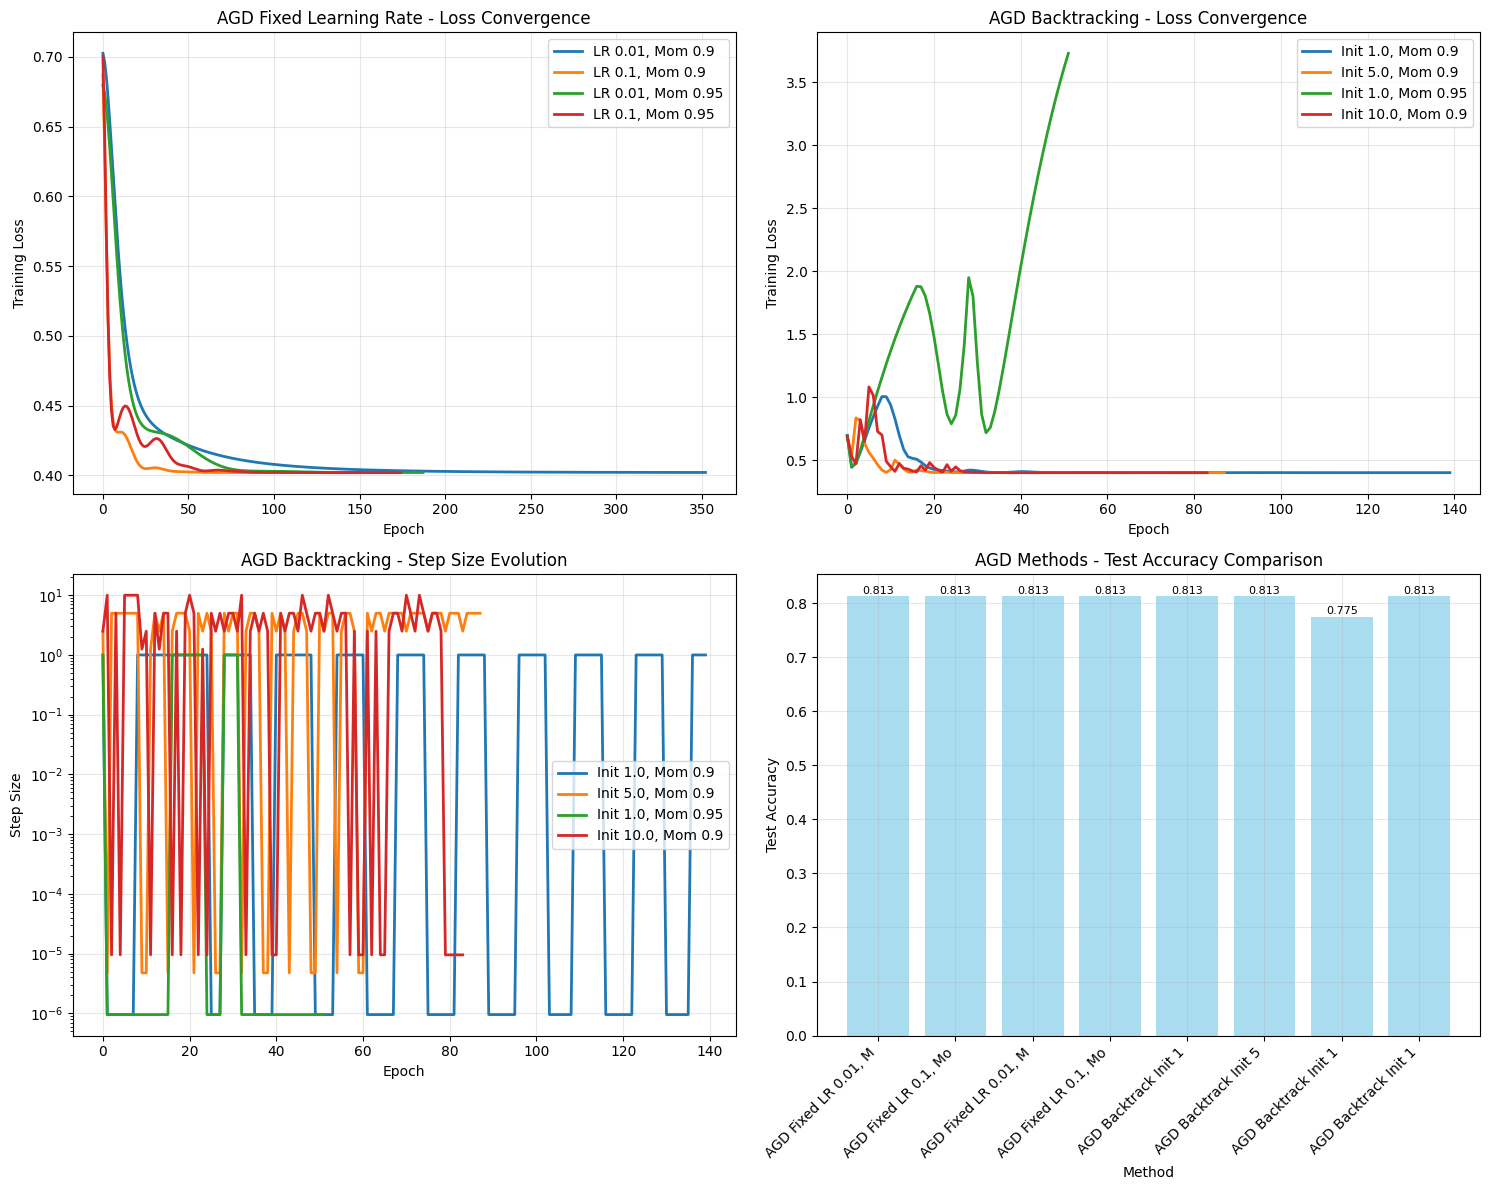

In [16]:
# Plot AGD convergence comparison
plot_agd_convergence_comparison(agd_comparison_results)

In [24]:
def plot_agd_loss_convergence(results):
    fixed_results = {k: v for k, v in results.items() if v["optimizer_type"] == "agd_fixed"}
    backtrack_results = {k: v for k, v in results.items() if v["optimizer_type"] == "agd_backtrack"}
    
    # Fixed learning rate
    plt.figure(figsize=(8, 6))
    for key, result in fixed_results.items():
        history = result["training_history"]
        plt.plot(
            history["epoch_history"],
            history["loss_history"],
            label=f'LR {result["lr"]}, Mom {result["momentum"]}',
            linewidth=2,
        )
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("AGD Fixed Learning Rate - Loss Convergence")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "agd" / "agd_loss_fixed.png")
    plt.close()
    
    # Backtracking
    plt.figure(figsize=(8, 6))
    for key, result in backtrack_results.items():
        history = result["training_history"]
        plt.plot(
            history["epoch_history"],
            history["loss_history"],
            label=f'Init {result["initial_step"]}, Mom {result["momentum"]}',
            linewidth=2,
        )
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("AGD Backtracking - Loss Convergence")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "agd" / "agd_loss_backtrack.png")
    plt.close()

plot_agd_loss_convergence(agd_comparison_results)

In [17]:
def compare_sgd_vs_agd():
    """
    Compare best performing SGD vs AGD methods.
    """
    print("Comparing Best SGD vs AGD Methods")
    print("=" * 50)
    
    results = {}
    MAX_EPOCHS = 2000
    EARLY_STOP_THRESHOLD = 1e-5
    
    # Test SGD with best configuration
    print("\n1. SGD with Fixed LR 0.1")
    sgd_optimizer = SGDOptimizer(
        learning_rate=0.1,
        max_epochs=MAX_EPOCHS,
        early_stop_patience=100,
        early_stop_threshold=EARLY_STOP_THRESHOLD,
        log_interval=100,
        verbose=True
    )
    sgd_model = LogisticRegressionSGD(optimizer=sgd_optimizer)
    
    start_time = time.time()
    sgd_model.fit(X_train_scaled, y_train, X_val_scaled, y_val)
    sgd_time = time.time() - start_time
    
    sgd_metrics = sgd_model.evaluate(X_test_scaled, y_test)
    results['SGD'] = {
        'model': sgd_model,
        'test_accuracy': sgd_metrics['accuracy'],
        'final_loss': sgd_metrics['loss'],
        'epochs': sgd_model.training_history['final_epoch'],
        'time': sgd_time
    }
    
    # Test AGD with best configuration
    print("\n2. AGD with Fixed LR 0.1, Momentum 0.95")
    agd_optimizer = AGDOptimizer(
        learning_rate=0.1,
        momentum=0.95,
        max_epochs=MAX_EPOCHS,
        early_stop_patience=100,
        early_stop_threshold=EARLY_STOP_THRESHOLD,
        log_interval=100,
        verbose=True
    )
    agd_model = LogisticRegressionAGD(optimizer=agd_optimizer)
    
    start_time = time.time()
    agd_model.fit(X_train_scaled, y_train, X_val_scaled, y_val)
    agd_time = time.time() - start_time
    
    agd_metrics = agd_model.evaluate(X_test_scaled, y_test)
    results['AGD'] = {
        'model': agd_model,
        'test_accuracy': agd_metrics['accuracy'],
        'final_loss': agd_metrics['loss'],
        'epochs': agd_model.training_history['final_epoch'],
        'time': agd_time
    }
    
    # Test AGD Backtracking
    print("\n3. AGD Backtracking with Initial Step 10.0, Momentum 0.9")
    agd_bt_optimizer = AGDBacktrackingOptimizer(
        initial_learning_rate=10.0,
        momentum=0.9,
        max_epochs=MAX_EPOCHS,
        early_stop_patience=100,
        early_stop_threshold=EARLY_STOP_THRESHOLD,
        log_interval=100,
        verbose=True
    )
    agd_bt_model = LogisticRegressionAGDBacktrack(optimizer=agd_bt_optimizer)
    
    start_time = time.time()
    agd_bt_model.fit(X_train_scaled, y_train, X_val_scaled, y_val)
    agd_bt_time = time.time() - start_time
    
    agd_bt_metrics = agd_bt_model.evaluate(X_test_scaled, y_test)
    results['AGD_Backtrack'] = {
        'model': agd_bt_model,
        'test_accuracy': agd_bt_metrics['accuracy'],
        'final_loss': agd_bt_metrics['loss'],
        'epochs': agd_bt_model.training_history['final_epoch'],
        'time': agd_bt_time
    }
    
    # Print comparison
    print("\n" + "="*70)
    print("SGD vs AGD COMPARISON SUMMARY")
    print("="*70)
    print(f"{'Method':<20} {'Epochs':<8} {'Final Loss':<12} {'Test Acc':<10} {'Time (s)':<10}")
    print("-"*70)
    
    for method, result in results.items():
        print(f"{method:<20} {result['epochs']:<8} {result['final_loss']:<12.6f} "
              f"{result['test_accuracy']:<10.4f} {result['time']:<10.2f}")
    
    # Plot comparison
    plt.figure(figsize=(15, 5))
    
    # Loss curves
    plt.subplot(1, 3, 1)
    for method, result in results.items():
        history = result['model'].training_history
        plt.plot(history['epoch_history'], history['loss_history'], 
                label=method, linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('SGD vs AGD - Loss Convergence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Performance bars
    plt.subplot(1, 3, 2)
    methods = list(results.keys())
    accuracies = [results[m]['test_accuracy'] for m in methods]
    plt.bar(methods, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy Comparison')
    plt.ylim(0.75, 0.82)
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.001, f'{acc:.4f}', ha='center', va='bottom')
    
    # Time comparison
    plt.subplot(1, 3, 3)
    times = [results[m]['time'] for m in methods]
    epochs = [results[m]['epochs'] for m in methods]
    plt.bar(methods, times, color=['skyblue', 'lightgreen', 'lightcoral'])
    plt.ylabel('Training Time (s)')
    plt.title('Training Time Comparison')
    for i, (time_val, epoch_val) in enumerate(zip(times, epochs)):
        plt.text(i, time_val + 0.5, f'{time_val:.1f}s\n{epoch_val} epochs', 
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return results

In [18]:
# Run SGD vs AGD comparison
sgd_vs_agd_results = compare_sgd_vs_agd()

Comparing Best SGD vs AGD Methods

1. SGD with Fixed LR 0.1


NameError: name 'SGDOptimizer' is not defined